<a href="https://colab.research.google.com/github/unique-subedi/ARSIA-review/blob/main/ARSIA_review_OL_statistical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from scipy.fftpack import dctn
from scipy.fftpack import idctn

# Sampling

Draw a sample from $\operatorname{N}(0, \alpha(-\nabla^2 +\beta \mathbf{I}))^{-\gamma}$ on $[0,1)^2$.

In [ ]:

def GRF(alpha, beta, gamma, N):
    # Random variables in KL expansion
    xi = np.random.randn(N, N)

    K1, K2 = np.meshgrid(np.arange(N), np.arange(N))

    # Define the (square root of) eigenvalues of the covariance operator
    coef = alpha**(1/2) *(4*np.pi**2 * (K1**2 + K2**2) + beta)**(-gamma / 2)

    # Construct the KL coefficients
    L = N * coef * xi

    #to make sure that the random field is mean 0
    L[0, 0] = 0

    return idctn(L, type =2)

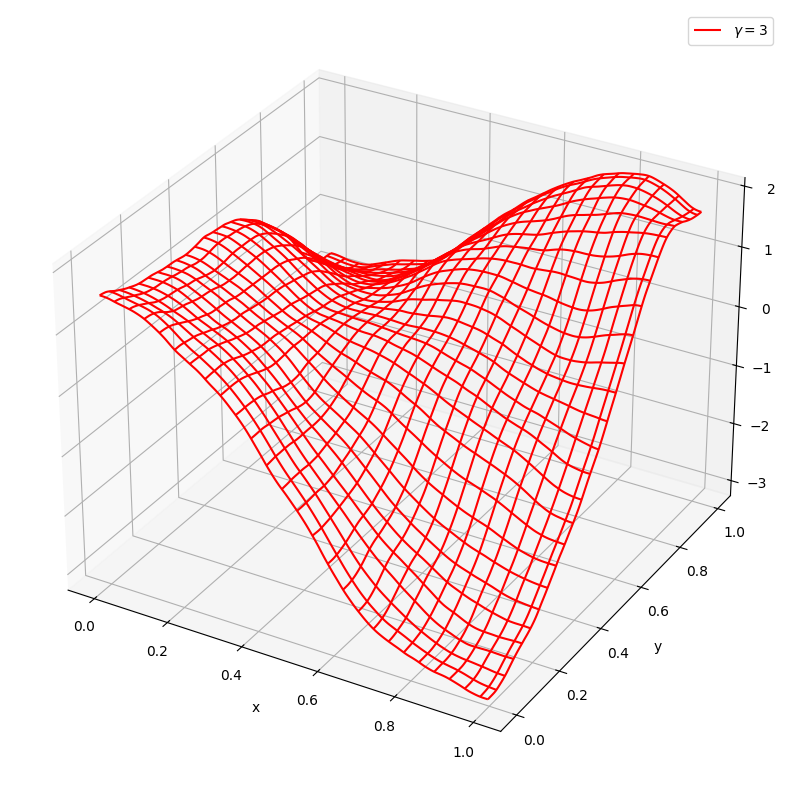

In [ ]:
alpha, beta, gamma=1, 1,3
N= 256
v=GRF(alpha, beta, gamma, N)

x=np.arange(0,1,1/N)
y=np.arange(0,1,1/N)
X, Y = np.meshgrid(x, y)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
wire = ax.plot_wireframe(X, Y, v, color='r', rstride=10, cstride=10, label=r'$\gamma=3$')
ax.set_xlabel('x')
ax.set_ylabel('y')
#ax.set_zlabel('v')
ax.legend(loc='best')
#plt.title(r'Boundary Values',fontsize=20,y=1.08)
plt.tight_layout()
plt.savefig('GRF3.png',dpi=300)
#plt.show()


# Heat Equation

Define the solver for heat equation. For simplicity, we use finite-difference method with forward Euler discretization.


In [ ]:
from scipy.sparse import diags, eye, kron
from scipy.sparse.linalg import inv, spsolve

def Laplacian(N):
    N2 = (N-1) * (N-1)
    h=1/N
    # Define diagonals for the discrete Laplacian operator
    main_diag = -4 * np.ones(N2)
    side_diag = np.ones(N2 - 1)
    side_diag[np.arange(1, N-1) * (N-1) - 1] = 0  # Adjust for block boundaries
    up_down_diag = np.ones(N2 - (N-1))

    # Create sparse matrix with specified diagonals
    L = (1/h**2)*diags([main_diag, side_diag, side_diag, up_down_diag, up_down_diag],
              [0, -1, 1, -(N-1), (N-1)], format="csc")

    return L


def solver(L,  u_0, Nt, tau):
  u_t =  u_0[1:, 1:].flatten()
  for i in range(Nt):
      u_t = u_t + dt * tau*L.dot(u_t)
  u= np.zeros((N,N))
  u[1:N,1:N]=u_t.reshape((N-1,N-1))
  return u

## Data Generation

In [ ]:
N = 64
L = Laplacian(N)
alpha = 1
beta = 1
gamma=1.5

Lx = 1  # Length of the rod in x-direction
Ly = 1  # Length of the rod in y-direction
T = 1.0    # Total time for simulation
Nt = 1000  # Number of time steps
tau = 0.05  # Thermal diffusivity

dx = Lx / (N-1)  # Spatial step in x-direction
dy = Ly / (N-1)  # Spatial step in y-direction
dt = T / Nt         # Time step

In [ ]:
n_train = 300
trainset = []
for i in range(0,n_train):
    u_0= GRF(alpha,beta,gamma,N)
    u = solver(L, u_0, Nt, tau)
    trainset.append({'x':  u_0,'y': u})


# Generate Test Samples
n_test = 100
valset = []
for i in range(0,n_test):
    f = GRF(alpha,beta,gamma,N)
    u = solver(L, u_0, Nt, tau)
    valset.append({'x':  u_0,'y': u})


testset = []
for i in range(0,n_test):
    u_0 = GRF(alpha,beta,gamma,N)
    u = solver(L, u_0, Nt, tau)
    testset.append({'x':  u_0,'y': u})

## Setup Neural Operator for Training

In [ ]:
!pip install torch
import torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [ ]:
!git clone https://github.com/NeuralOperator/neuraloperator
import sys
sys.path.append("neuraloperator")
import neuraloperator


Cloning into 'neuraloperator'...
remote: Enumerating objects: 13037, done.
remote: Counting objects: 100% (194/194), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 13037 (delta 108), reused 66 (delta 57), pack-reused 12843 (from 4)
Receiving objects: 100% (13037/13037), 99.29 MiB | 16.23 MiB/s, done.
Resolving deltas: 100% (8509/8509), done.


In [ ]:
!pip3 install tensorly
!pip3 install tensorly-torch
!pip3 install torch_harmonics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 9.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_harmonics: filename=torch_harmonics-0.7.4-py3-none-any.whl size=94100 sha256=a591eab109756754ea40707abd0793b25c6e842f47e5cfe604e7599bb014e220
  Stored in directory: /root/.cache/pip/wheels/88/e3/c6/f1590bce53ab6afdfcb4c59d2dd5157be7e1bc6196db8d1e99
Successfully built torch_harmonics


Use GPU as your device if available.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Required functions for training.

In [ ]:
from torch.utils.data import DataLoader, Dataset
from neuralop.models import FNO
from neuralop.utils import count_model_params
from neuralop import LpLoss
from neuralop.training import Trainer


Setup dataset as a torch tensor object.

In [ ]:
trainset_torch = []
for s in trainset:
        trainset_torch.append(  {
              'x': torch.tensor(s['x'], dtype = torch.float32).reshape(1,N,N),
              'y': torch.tensor(s['y'],dtype = torch.float32).reshape(1,N,N)
          })

valset_torch = []


for s in valset:
        valset_torch.append(  {
              'x': torch.tensor(s['x'], dtype = torch.float32).reshape(1,N,N),
              'y': torch.tensor(s['y'],dtype = torch.float32).reshape(1,N,N)
          })


testset_torch = []


for s in testset:
        testset_torch.append(  {
              'x': torch.tensor(s['x'], dtype = torch.float32).reshape(1,N,N),
              'y': torch.tensor(s['y'],dtype = torch.float32).reshape(1,N,N)
          })

trainloader = DataLoader(trainset_torch, batch_size=32, shuffle=True)
valloaders = {"same_grid": DataLoader(valset_torch, batch_size=32, shuffle=True)}
testloaders = {'same_grid': DataLoader(testset_torch, batch_size=32, shuffle=True)}


Define model, optimizer, and loss function.

In [ ]:

f_modes = int(N/2)
model = FNO(n_modes=(f_modes,) * 2, hidden_channels=32, projection_channels=64, num_layers=4,
                in_channels=1, out_channels=1)
operator = model.to(device)

optimizer = torch.optim.Adam(operator.parameters(), lr=8e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

l2loss = LpLoss(d=2, p=2)
train_loss = l2loss
eval_losses={'l2': l2loss}

Setup the trainer and train the model.

In [ ]:

trainer = Trainer(model=operator, n_epochs=200, #adjust number of epochs as needed
                      device=device,
                      eval_interval=10,
                      log_output=False,
                      use_distributed=False,
                      verbose=True)

trainer.train(train_loader=trainloader,
                  test_loaders =valloaders,
                  eval_losses=eval_losses,
                  optimizer=optimizer,
                  scheduler=scheduler,
                  regularizer=False,
                  training_loss=train_loss)

Training on 300 samples
Testing on [100] samples         on resolutions ['same_grid'].
Raw outputs of shape torch.Size([32, 1, 64, 64])
[0] time=0.15, avg_loss=1.0151, train_err=30.4519
Eval: same_grid_l2=0.7750
[10] time=0.14, avg_loss=0.2840, train_err=8.5187
Eval: same_grid_l2=0.2279
[20] time=0.14, avg_loss=0.1023, train_err=3.0683
Eval: same_grid_l2=0.0901
[30] time=0.14, avg_loss=0.0553, train_err=1.6586
Eval: same_grid_l2=0.0476
[40] time=0.14, avg_loss=0.0640, train_err=1.9194
Eval: same_grid_l2=0.0876
[50] time=0.14, avg_loss=0.2109, train_err=6.3280
Eval: same_grid_l2=0.3197
[60] time=0.14, avg_loss=0.1255, train_err=3.7640
Eval: same_grid_l2=0.1198
[70] time=0.14, avg_loss=0.0787, train_err=2.3605
Eval: same_grid_l2=0.0573
[80] time=0.14, avg_loss=0.0376, train_err=1.1268
Eval: same_grid_l2=0.0278
[90] time=0.14, avg_loss=0.0200, train_err=0.6006
Eval: same_grid_l2=0.0157
[100] time=0.14, avg_loss=0.0222, train_err=0.6665
Eval: same_grid_l2=0.0290
[110] time=0.14, avg_loss=0

{'train_err': 0.8198543936014175,
 'avg_loss': 0.02732847978671392,
 'avg_lasso_loss': None,
 'epoch_train_time': 0.1377846469999895}

Evaluate the trained model.

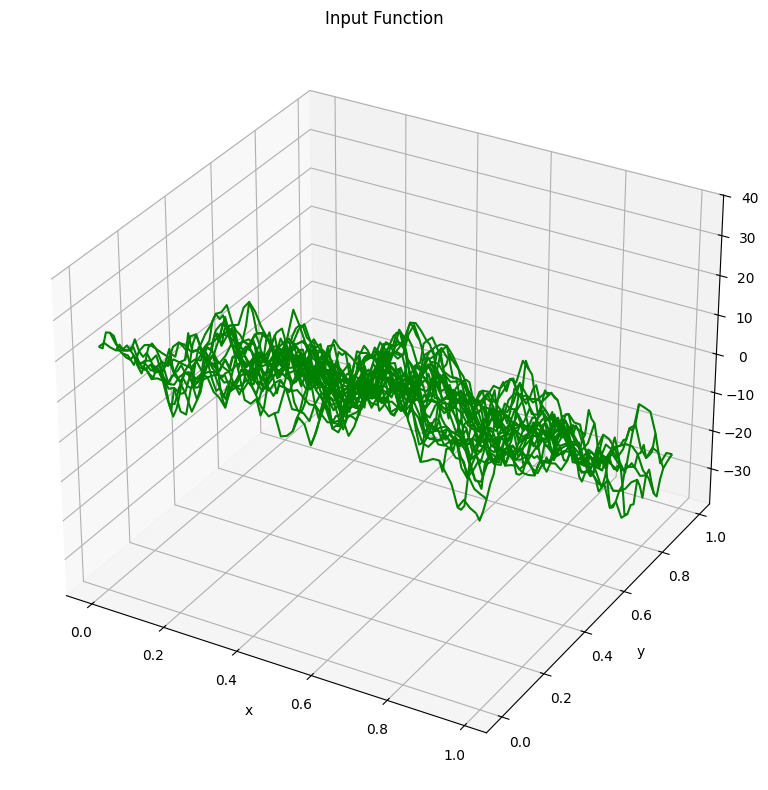

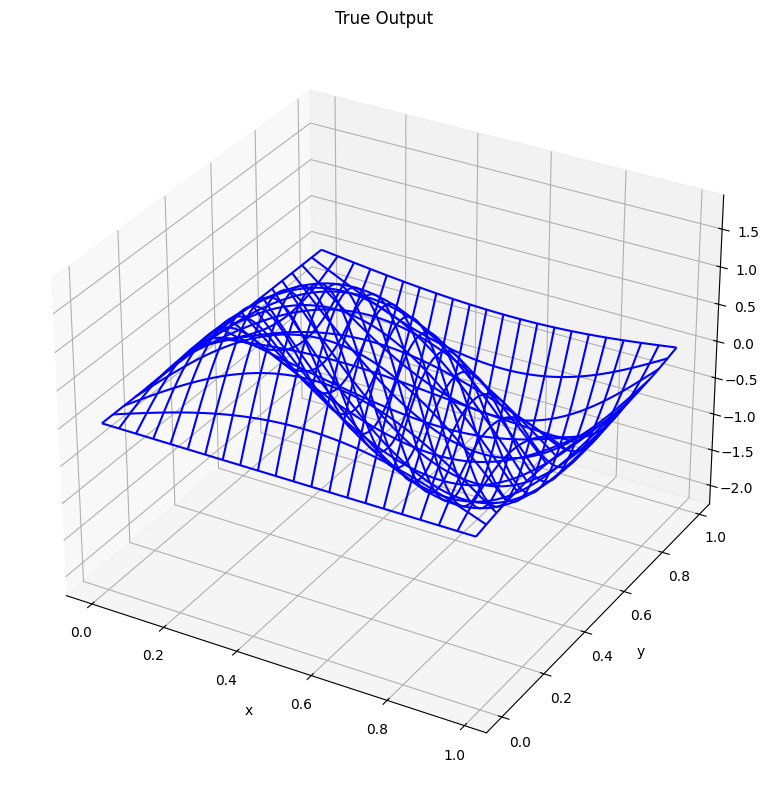

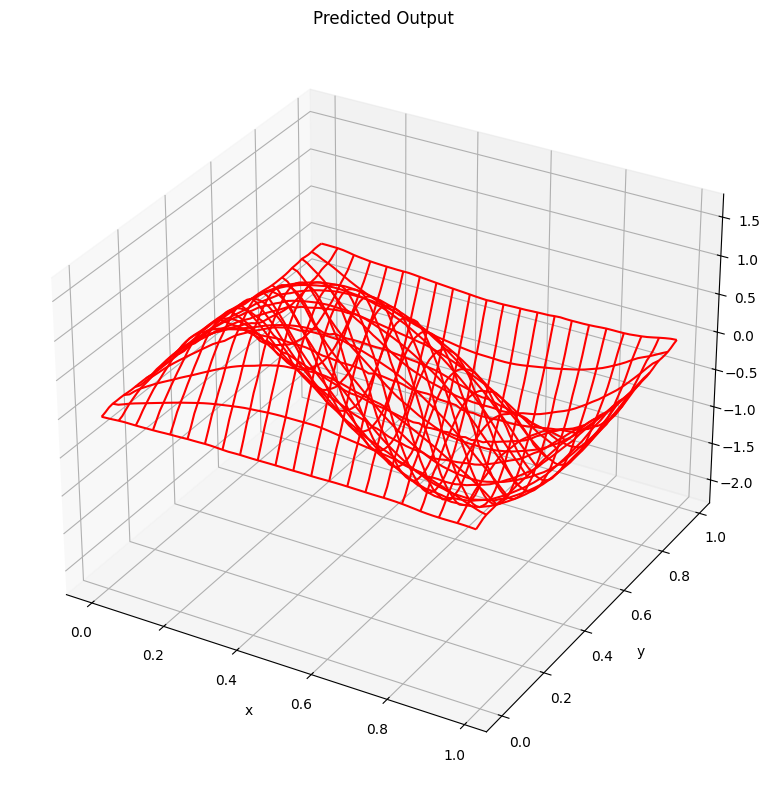

In [ ]:
import random


random_index = random.randint(0, len(testset_torch) - 1)
random_sample = testset_torch[random_index]


input_actual = random_sample['x'].to(device)
y_actual = random_sample['y'].to(device)


operator.eval()
with torch.no_grad():
    y_pred = operator(input_actual.unsqueeze(0))



y_pred = y_pred.squeeze(0).cpu().numpy()[0, :, :]
y_actual = y_actual.cpu().numpy()[0, :, :]



x = np.arange(0,1, 1/N)
y = np.arange(0,1, 1/N)
X, Y = np.meshgrid(x, y)


fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111, projection='3d')
ax1.plot_wireframe(X, Y, input_actual.cpu().numpy()[0,:,:], color='g', rstride=3, cstride=3, label='Input Actual')
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("z")
ax1.set_title("Input Function")
plt.tight_layout()
plt.savefig('input.png', dpi=300)


# Plot the actual output as a wireframe
fig = plt.figure(figsize=(8,8))
ax2 = fig.add_subplot(111, projection='3d')
ax2.plot_wireframe(X, Y, y_actual, color='b', rstride=3, cstride=3, label='Actual')
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("z")
ax2.set_title("True Output")
plt.tight_layout()
plt.savefig('actual.png', dpi=300)

# Plot the predicted output as a wireframe
fig = plt.figure(figsize=(8,8))
ax3 = fig.add_subplot(111, projection='3d')
ax3.plot_wireframe(X, Y, y_pred, color='r', rstride=3, cstride=3, label='Predicted')
ax3.set_xlabel("x")
ax3.set_ylabel("y")
ax3.set_zlabel("z")
ax3.set_title("Predicted Output")
plt.tight_layout()
plt.savefig('predicted.png', dpi=300)

#Plot the input actual

plt.tight_layout()
plt.show()




In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(y_actual, cmap='cividis_r')
plt.title("Actual Output")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(y_pred, cmap='cividis_r')
plt.title("Predicted Output")
plt.colorbar()

plt.show()

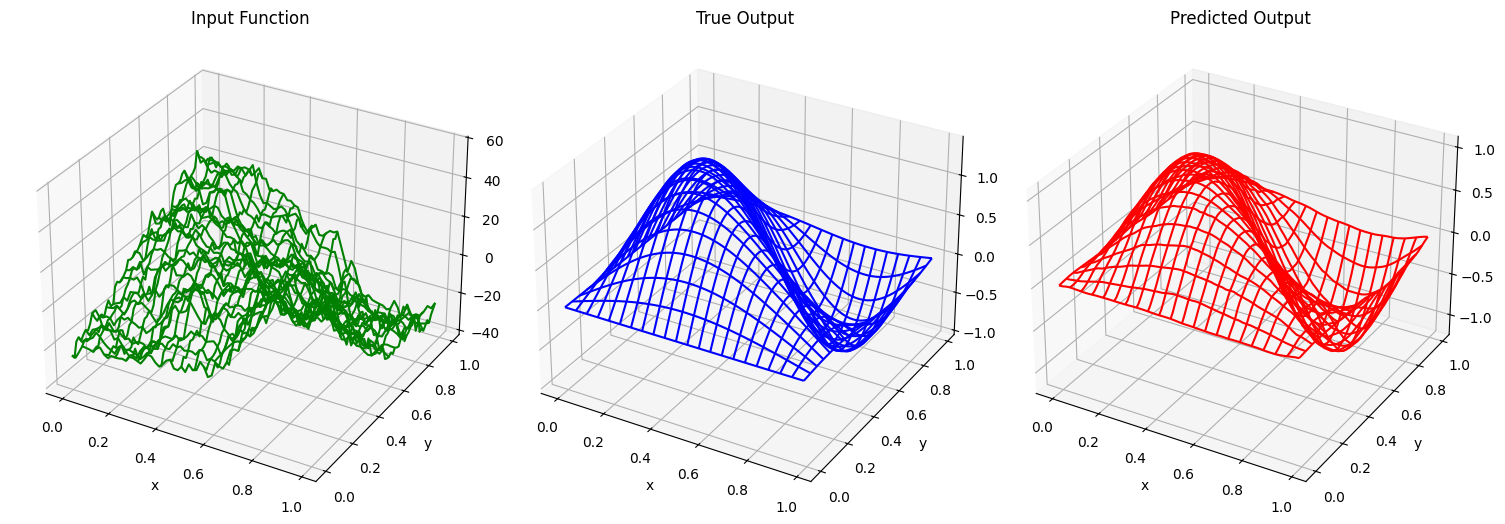